# Regression with K-nearest neighbors

In this tutorial, we will go over K-nearest neighbors, or KNN regression, a simple machine learning algorithm that can nonetheless be used with great success. Essentially, given some unlabelled input, the KNN algorithm looks for the nearest neighbors of an input, and uses those neighbors to predict the label of the input. By the end of this tutorial, you will know:
1. How exactly KNN algorithm works.
2. How to process data to feed into the KNN algorithm
3. How to tune the KNN algorithm for best performance. 
4. The benefits and limitations of the KNN algorithm

In this tutorial, we'll use the KNN algorithm to predict median house prices of districts in California, as well as apply the algorithm to a condensed matter physics problem. First, if running a Google Colab instance, you'll need to pull the data manually.

In [1]:
#!curl -o spectral_data.npz https://raw.githubusercontent.com/JackieLee23/KNN-Tutorial/main/spectral_data.npz

## The Dataset

To get a sense of what the KNN algorithm is doing, we'll be working with a real life example. Let's import libraries we'll need first, and set some defaults for plotting that we'll need later. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.datasets import fetch_california_housing
plt.rcParams['figure.dpi'] = 250
plt.rcParams["figure.figsize"] = [3, 2]
plt.rcParams["font.size"] = 5

In this tutorial, we'll be looking at a dataset of house prices in different California districts. Given different features of houses in a district, we want to try to predict the median house price in that district. 

Let's start by downloading the dataset, and seeing what exactly the features are. 

In [3]:
housing_data = fetch_california_housing(as_frame = True)
housing_df = housing_data['frame']
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We can see that there are 9 columns total: the first 8 are the **features** of the houses in each district, while the last column is the **target** we're trying to predict - the median house price, in hundreds of thousands of dollars. I've used the data analysis library pandas to see this table - more information on pandas can be found in their [documentation](https://pandas.pydata.org/docs/user_guide/index.html). The housing_df variable is a pandas **dataframe** - essentially a table with each row being a datapoint, and the columns being different features. 

## Intuition and Motivation

To start, let's visualize what KNN is doing on a small subset of the data, and only look at two of the features - median income, and number of rooms. I'll use the plotting library [matplotlib](https://matplotlib.org/stable/tutorials/introductory/quick_start.html#sphx-glr-tutorials-introductory-quick-start-py) to make a scatterplot of this subset, with the points labelled and colored by the median house price.

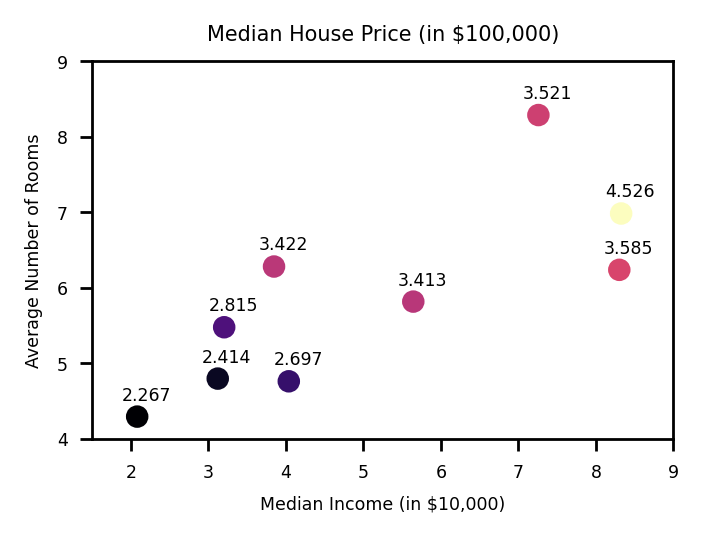

In [4]:
indices = [0, 1, 2, 3, 4, 5, 7, 8, 10]
x_coords = housing_df.loc[indices, 'MedInc'].to_numpy()
y_coords = housing_df.loc[indices, 'AveRooms'].to_numpy()
house_values = housing_df.loc[indices, 'MedHouseVal'].to_numpy()

def scatter_known(ax):
    ax.scatter(x_coords, y_coords, s = 30, c = house_values, cmap = 'magma')
    ax.set_xlim(1.5, 9)
    ax.set_ylim(4.0, 9.0)
    ax.set_xlabel("Median Income (in $10,000)")
    ax.set_ylabel("Average Number of Rooms")
    ax.set_title("Median House Price (in $100,000)")

    for x, y, label in zip(x_coords, y_coords, house_values):
        ax.annotate(f"{label}", (x, y), xytext = (x - 0.2, y + 0.22))
        
fig, ax = plt.subplots()
scatter_known(ax)

Now here is the canonical supervised machine learning probem: given a **new** district, for which we don't know the house value, can we use the labelled data points to predict its value? I've plotted a mock new data point below. 

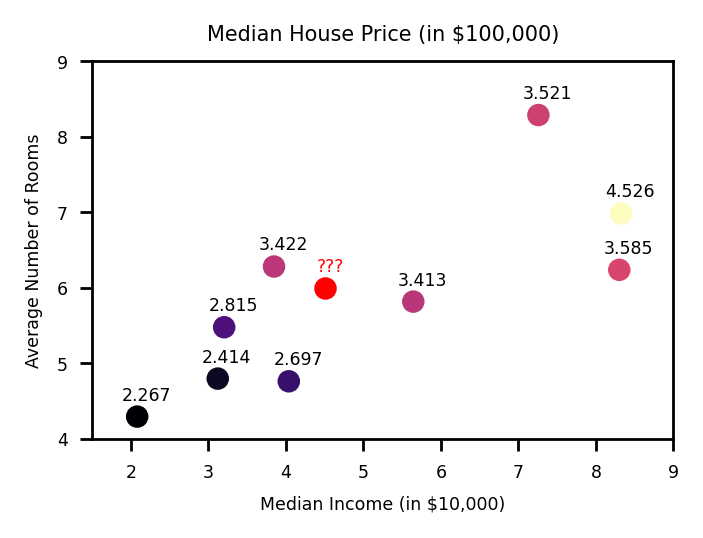

In [5]:
unknown_x, unknown_y = 4.5, 6

def scatter_unknown(ax, label_pred = None):
    ax.scatter([unknown_x], [unknown_y], color = "red", s = 30) 
    ax.annotate("???", (unknown_x, unknown_y), xytext = (unknown_x - 0.1, unknown_y + 0.22), color = "red");
    
fig, ax = plt.subplots()
scatter_known(ax)
scatter_unknown(ax)

There are a lot of different ways that we could go about predicting the label for this new datapoint. One of the simplest ways is by simply guessing that this point should have roughly the same label as the closest point on the graph - the purple point with value 3.422 to the left of the red point. More formally, we're finding the closest labelled point in **feature space** (the axis being the features). 

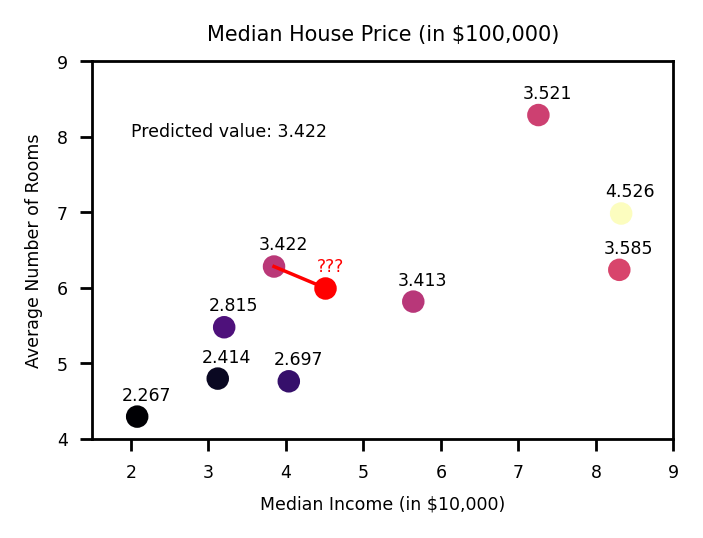

In [10]:
fig, ax = plt.subplots()
nearest_x, nearest_y, nearest_label = x_coords[4], y_coords[4], house_values[4]
        
ax.plot([unknown_x, nearest_x], [unknown_y, nearest_y], color = "red", linewidth = 1)
scatter_known(ax)
scatter_unknown(ax, label_pred = nearest_label)
ax.text(2, 8, f"Predicted value: {nearest_label}", fontsize = 5);

That's great, but can we really trust a single point? It seems problematic that we're using a single point to predict our label - what if that point is an outlier? We'd also expect our prediction to be rather biased, as we're choosing a point to the left.

A solution is to use more neighbors - instead of looking at just one point, let's use the **k nearest** labelled neighbors. In the cell below, we'll take the k closest points in parameter space in terms of $L_2$ distance, and take the average label of those points to be our predicted output. Let's first set some value of k:

In [15]:
k = 9   #Play around with this K value!

And then visualize what the algorithm is doing; don't worry too much about the specific python implementation right now - just focus on the outputted graph.

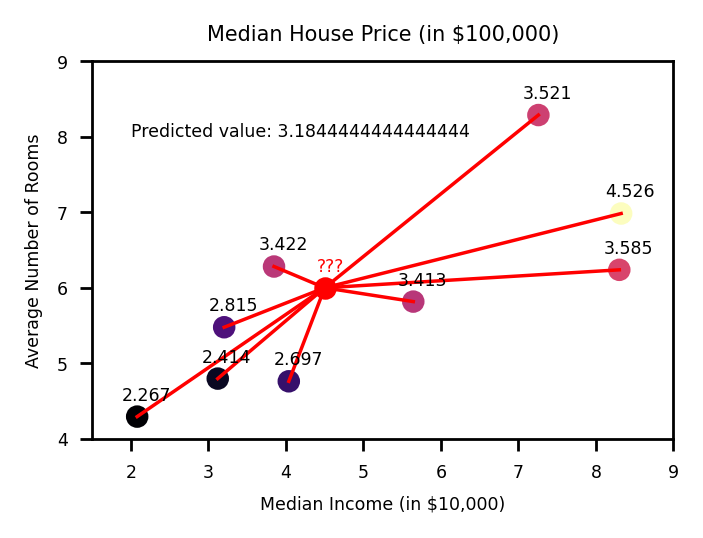

In [16]:
l2_arr = (x_coords - unknown_x) ** 2 + (y_coords - unknown_y) ** 2
sorted_inds = np.argsort(l2_arr)
sorted_x = x_coords[sorted_inds]
sorted_y = y_coords[sorted_inds]
sorted_labels = house_values[sorted_inds]
predicted_label = np.mean(sorted_labels[:k])

fig, ax = plt.subplots()
for x, y in zip(sorted_x[:k], sorted_y[:k]):
    ax.plot([unknown_x, x], [unknown_y, y], color = "red", linewidth = 1)
    
scatter_known(ax)
scatter_unknown(ax, label_pred = predicted_label)
ax.text(2, 8, f"Predicted value: {predicted_label}", fontsize = 5);

This is the **K-nearest neighbors (KNN)** algorithm! By playing around with the value of k above, we can see how the prediction changes. Intuitively, it makes sense that having too small of a k is not a good idea - our prediction will be highly sensitive to the peculiarities of the surrounding data. Having too large of a k is also not a great idea - we'll be using datapoints with very different features to make predictions.

## Questions to Consider

The above example raises some questions:
1. How do we determine how many neighbors to look at - that is, what is k?
2. Should we weigh neighbors nearby in parameter space equally as neighbors that are far away? If so, how do we know what weighting scheme to use?
3. What happens if we don't use $L_2$ distance to find neighbors, but some other distance metric? How do we choose a good metric to use?

We'll be exploring answers to these questions in the following section, where we'll be using the full dataset, and the full set of features, to make predictions. 

## The KNN algorithm in depth - data processing

The first step of data processing is to store the input features, and the target labels, as [numpy arrays](https://numpy.org/devdocs/user/quickstart.html) - when working with machine learning libraries, this is almost always how data is represented for fast processing. 

In [17]:
X = housing_data['data'].to_numpy()
y = housing_data['target'].to_numpy()
y.shape

(20640,)

We can see that our full dataset consists of 20,640 districts, with 8 features each; in the numpy array, this is represented as a matrix with 20,640 rows, and 8 columns. Our target consists of 20,640 house prices - an array with 20,640 entries.

Our goal now is to see how the KNN algorithm performs on new data that it hasn't seen before. For this reason, we'll split our existing dataset into a **training set**, and a **testing set**. 
* The **training set** constitutes the labelled datapoints.
* The **testing set** is where we'll try to predict the labels of the datapoints, using their input features:


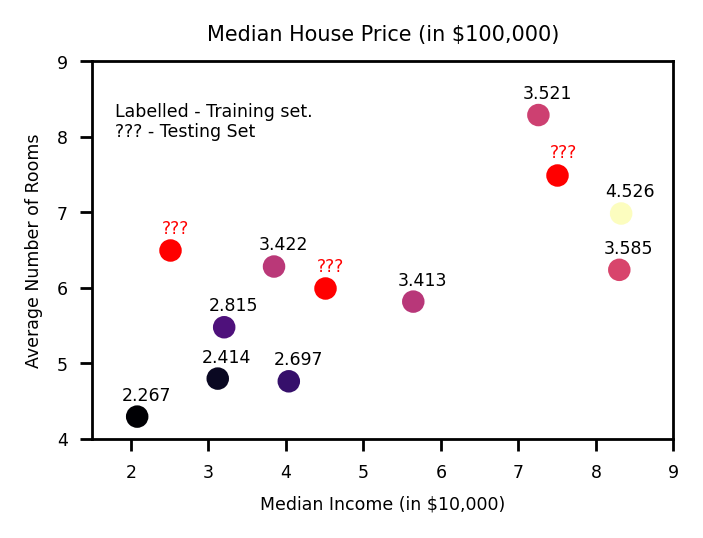

In [18]:
fig, ax = plt.subplots()

test_x = [4.5, 2.5, 7.5]
test_y = [6, 6.5, 7.5]
ax.scatter([test_x], [test_y], color = "red", s = 30) 
for x_coord, y_coord in zip(test_x, test_y):
    ax.annotate("???", (x_coord, y_coord), xytext = (x_coord - 0.1, y_coord + 0.22), color = "red");
    
scatter_known(ax)
ax.text(1.8, 8, "Labelled - Training set. \n??? - Testing Set");

To evaluate how KNN is doing, we'll first use KNN to predict the labels of the points in the test set. Then, we'll see how closely those predictions match the actual labels of the testing set - that is, we'll find the **test error**. Scikit-learn, a free machine learning library in python, does a randomized training and testing split for us. 

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape

(16512, 8)

Here, we've split the dataset into 80 percent training, and 20 percent testing. 

Now, remember that we're trying to determine the value of k. We could see one possible way that we could do this - we could try out different values of k until we find one that minimizes the test error. So we deliver the lowest possible test error, and we've optimized our KNN algorithm! Right?

The problem with the above approach is that we've cheated - we're *using* the testing set to tune the value of k. Therefore, the test error no longer faithfully represents how well the algorithm performs on new, unseen data - we've already used the testing set to fit k. 

We can remedy this by further splitting the training set into training and **validation** sets. We'll first try to predict the labels of the *validation* set, and use this to tune k. Once we find a good value of k, we'll use the testing set to get an unbiased evaluation of the KNN performance. 

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
X_train.shape

(13209, 8)

Some machine learning terminology: K is a **hyperparameter** - a parameter that is not learned by fitting to the training set. Rather, it's a parameter of the model that you set *before* you start using the training set to make predictions. Hyperparameters are chosen by evaluation on the validation set, just as we're doing.

The last step of preparing data for KNN is to **scale** the features, so that each feature takes on roughly the same range of values. For instance, if feature X1 has values in the range (0, 100), while feature X2 has values in the range (0, 1), feature X1 will dominate when we're searching for nearest neighbors - the nearest neighbors will almost entirely be determined by the closest values of X1! For this reason, we **scale** X1 and X2 to occupy roughly the same range. 

We'll use scikit-learn's MinMaxScaler, which linearly scales each feature to have minimum 0 and maximum 1. 

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## The Simplest KNN Algorithm - implementation

We're now ready to actually implement the KNN algorithm. Let's first look at an example where we use 3 neighbors, and see how KNN predicts the first example of the validation set. 

In [23]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors = 3)
neigh.fit(X_train_scaled, y_train)
neigh.predict(X_val_scaled[:1])

array([0.78433333])

We can predict the labels of every entry in the validation set:

In [24]:
pred_val = neigh.predict(X_val_scaled)
pred_val

array([0.78433333, 0.98433333, 1.96966667, ..., 2.81966667, 2.10033333,
       1.87233333])

And we can see how far this is from the actual labels of the validation set. To do this, we'll use the **mean squared error** between the predicted and acutal labels:

In [25]:
from sklearn.metrics import mean_squared_error
mean_squared_error(pred_val, y_val)

0.4282112450275238

Now, our goal is to find a value of k that will minimize this validation error: For that, we can simply loop through different values of k. We'll store the errors in the y_errors array. 

In [27]:
y_errors = []
for k in range(1, 21):
    neigh = KNeighborsRegressor(n_neighbors = k)
    neigh.fit(X_train_scaled, y_train)
    y_pred = neigh.predict(X_val_scaled)
    y_error = mean_squared_error(y_pred, y_val)
    y_errors.append(y_error)
    
y_errors = np.array(y_errors)
y_errors

array([0.59440684, 0.46646322, 0.42821125, 0.42125579, 0.4151477 ,
       0.40788635, 0.40337121, 0.40113356, 0.40675846, 0.40623549,
       0.4054183 , 0.40755986, 0.4090275 , 0.40874763, 0.41137133,
       0.41280625, 0.41337963, 0.41568718, 0.4177379 , 0.41826095])

Let's take a look at how the error changes for different values of k:

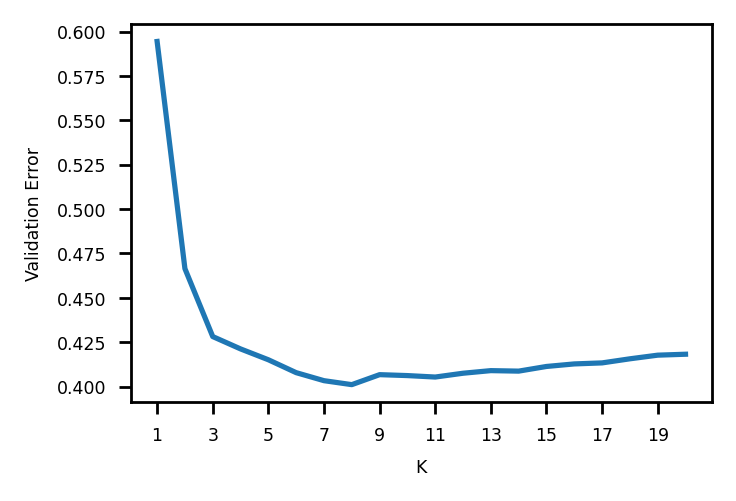

In [29]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 21), y_errors)
ax.set_xticks(np.arange(1, 21, 2));
ax.set_xlabel("K")
ax.set_ylabel("Validation Error");

We can see that the error is pretty large for low values of k, and as we increase k, it looks like the error drops until k = 8, where it's about 0.400, after which it starts rising again. This is typical of KNN, and is just like we hypothesized earlier: values of k that are both too small and too large will lead to greater error. Let's confirm that k = 8 is indeed the optimal value, and find the mean squared error on the validation set:

In [30]:
best_k = np.argmin(y_errors) + 1 #Add 1 due to the 0-index corresponding to k = 1
best_mse = np.min(y_errors)
print(f"Best value of k: {best_k}, best mean squared error: {best_mse}")

Best value of k: 8, best mean squared error: 0.4011335589389357


Now, at this point, you might be asking: how good is this 0.401 number actually? Is this model actually doing anything?

One way that we can get a sense of how well the model is performing on the validation set is by comparing the mean squared error with a model that simply predicts the average every time. That is, if the validation set has ground truth labels $y^{(1)}, y^{(2)}, ... y^{(n)}$, a baseline model would just predict $\bar{y}$ for every point in the set. So then the mean squared error of this baseline model would be:
$$MSE = \frac{1}{n} \sum_{i}(y^{(i)} - \bar{y})^2$$

If that looks familiar, that's because it's just the variance of the data! So, we'd better hope that the mean squared error from K-nearest neighbors is better than the variance of the validation set - or else we might as well just be guessing the average every time. Let's see what the variance of the validation set is:

In [31]:
np.var(y_val)

1.3799878712507327

That's comforting! Our simple KNN algorithm is doing quite a bit better than the baseline, at least on the validation set. The question, of course, is whether we can do even better than this. One way that we can improve our performance is by taking into account the distance to the neighbors that we use. That is, when we're deciding the value of some point, we want to consider points close by in parameter space with more weight. We'll explore this in the next section.

## Weighted KNN Regression

Let's formalize the idea above a little bit. In the last section, we came up with a model where we take an unlabelled input, look at the k closest labelled points in parameter space, and take the average label of those points as our prediction. In a weighted scheme, we instead take the **weighted average** of those points to predict the output.

Let's start off with a simple weighting scheme: we'll take the weights to be inversely proportional to the distance to the point. Thankfully, scikit-learn already has a built in option for this - we just need to specify the *weights* keyword when defining the model. 

In [32]:
neigh = KNeighborsRegressor(n_neighbors = 3, weights = 'distance')
neigh.fit(X_train_scaled, y_train)
neigh.predict(X_val_scaled[:1])

array([0.77909189])

Of course, now that we're using a new weighting scheme, we might have a different optimal value of k. Let's run through the same process as before to find the best value of k:

In [33]:
weighted_errors = []
for k in range(1, 21):
    neigh = KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    neigh.fit(X_train_scaled, y_train)
    y_pred = neigh.predict(X_val_scaled)
    error = mean_squared_error(y_pred, y_val)
    weighted_errors.append(error)
    
weighted_errors = np.array(weighted_errors)
best_k = np.argmin(weighted_errors) + 1 #Add 1 due to the 0-index corresponding to k = 1
best_mse = np.min(weighted_errors)
print(f"Best value of k: {best_k}, best mean squared error: {best_mse}")

Best value of k: 8, best mean squared error: 0.39273734091117624


So it seems that the best value of k is still 8. However, with this weighting scheme, we've managed to improve the mean squared error when compared to the unweighted algorithm from the last section. 

Of course, we can use other weighting schemes as well - we just want any monotonically decreasing function of distance. Let's see how we would implement a weighting scheme where the weights are inversely proportional to the *square* of the distance.

In [34]:
def weight_function(distances):
    return 1 / distances ** 2

neigh = KNeighborsRegressor(n_neighbors = 3, weights = weight_function)
neigh.fit(X_train_scaled, y_train)
neigh.predict(X_val_scaled[:1])

array([0.77369169])

To create a custom weight function, as above, we just need to create a function that accepts an array of distances, and returns an array of the same shape containing the weights. We can also rewrite the above using a [lambda function](https://www.w3schools.com/python/python_lambda.asp):

In [35]:
neigh = KNeighborsRegressor(n_neighbors = 3, weights = lambda d: 1/d**2)
neigh.fit(X_train_scaled, y_train)
neigh.predict(X_val_scaled[:1])

array([0.77369169])

And find the best k and corresponding mean squared error again:

In [36]:
weighted_errors = []
for k in range(1, 21):
    neigh = KNeighborsRegressor(n_neighbors = k, weights = lambda d:1/d**2)
    neigh.fit(X_train_scaled, y_train)
    y_pred = neigh.predict(X_val_scaled)
    error = mean_squared_error(y_pred, y_val)
    weighted_errors.append(error)
    
weighted_errors = np.array(weighted_errors)
best_k = np.argmin(weighted_errors) + 1 #Add 1 due to the 0-index corresponding to k = 1
best_mse = np.min(weighted_errors)
print(f"Best value of k: {best_k}, best mean squared error: {best_mse}")

Best value of k: 11, best mean squared error: 0.38865236482894255


Notice that the optimal value of k is no longer 8, and that the mean squared error has dropped again! 

What happens if we keep going - if we use the inverse distance *cubed* as the weighting, or the inverse distance to the fourth power? It seems rather cumbersome to manually check every case - let's add another loop to do this for us. We'll loop over every value of $\alpha$, defining the weighting scheme $\frac{1}{d^\alpha}$, and find the best $k$ value for each $\alpha$. Notice that the weighting scheme is another hyperparameter!

In [37]:
max_alpha = 4
max_k = 20
weighted_errors = np.zeros((max_alpha, max_k))
for alpha in range(1, max_alpha + 1):
    print(f"Running alpha = {alpha}")
    for k in range(1, max_k + 1):
        neigh = KNeighborsRegressor(n_neighbors = k, weights = lambda d:1/d**alpha)
        neigh.fit(X_train_scaled, y_train)
        y_pred = neigh.predict(X_val_scaled)
        
        error = mean_squared_error(y_pred, y_val)
        weighted_errors[alpha - 1, k - 1] = error
        
best_index = np.unravel_index(np.argmin(weighted_errors), weighted_errors.shape)
best_alpha = best_index[0] + 1
best_k = best_index[1] + 1
best_mse = np.min(weighted_errors)

print(f"best alpha: {best_alpha}, best k: {best_k}, best mse: {best_mse}")

Running alpha = 1
Running alpha = 2
Running alpha = 3
Running alpha = 4
best alpha: 3, best k: 16, best mse: 0.3883717507033637


The above is an example of **grid search** for hyperparameters. Grid search can be used in many ML algorithms to find optimal hyperparameters - though you can see how it can quickly become very expensive when there are more hyperparameters! 

We've managed to get the mean squared error down to 0.3884 by optimizing $\alpha$ and k. Of course, there are an infinite number of weighting schemes we can use, not necessarily just inverse powers of distance - and it may be that one of them performs better. In practice, it's up to you to decide how much time you want to spend tuning hyperparameters. It may be that squeezing out a little better performance is worth the extra time you take to find that perfect weighting scheme. That's up to the specific problem at hand. 

For now, though, let's move on and try one more trick to get better performance: using a different distance metric.

## Changing The Distance Metric

Up until now, we've been using $L_2$ distance in feature space to find nearest neighbors, and to assign weights for the weighted KNN. But we aren't limited to just $L_2$ distance! In general, we can use the [Minkowski distance](https://en.wikipedia.org/wiki/Minkowski_distance) between points X and Y:
$$D(X, Y) = \left(\sum_{i=1}^{n}|x_i-y_i|^p\right)^{\frac{1}{p}}$$

Where p is the power parameter. So we can take p to be another hyperparameter to tune! In practice, though, we'll usually just  use p = 1 or p = 2. When p = 1:
$$D(X, Y) = \sum_{i=1}^{n}|x_i-y_i|$$

Which is the [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry), also called the $L_1$ distance. When p = 2, we get:
$$D(X, Y) = \left(\sum_{i=1}^{n}|x_i-y_i|^2\right)^{\frac{1}{2}}$$
Which is the familiar $L_2$ distance that we've been using. Let's see how KNN works when we use the Manhattan distance:

In [38]:
neigh = KNeighborsRegressor(n_neighbors = 3, p = 1)
neigh.fit(X_train_scaled, y_train)
neigh.predict(X_val_scaled[:1])

array([0.81833333])

Scikit-learn lets us set the Minkowski power parameter p, so we just set it as 1 to use Manhattan distance to do nearest neighbors search, and for the input to the weighting function if there is one. Now, we can repeat grid search over $\alpha$ and k like we did before:

In [39]:
max_alpha = 4
max_k = 20
power_param = 1
weighted_errors = np.zeros((max_alpha + 1, max_k))

for alpha in range(max_alpha + 1):
    print(f"Running alpha = {alpha}")
    for k in range(1, max_k + 1):
        neigh = KNeighborsRegressor(n_neighbors = k, weights = lambda d:1/d**alpha, p = power_param)
        neigh.fit(X_train_scaled, y_train)
        y_pred = neigh.predict(X_val_scaled)
        
        error = mean_squared_error(y_pred, y_val)
        weighted_errors[alpha, k - 1] = error
        
best_index = np.unravel_index(np.argmin(weighted_errors), weighted_errors.shape)
best_alpha = best_index[0]
best_k = best_index[1] + 1
best_mse = np.min(weighted_errors)

print(f"best alpha: {best_alpha}, best k: {best_k}, best mse: {best_mse}")

Running alpha = 0
Running alpha = 1
Running alpha = 2
Running alpha = 3
Running alpha = 4
best alpha: 3, best k: 17, best mse: 0.3577203559104934


Notice that I'm searching over $\alpha = 0$ now, which is the unweighted KNN case. We can see that the best mean squared error has dropped down to 0.358! 

Now, in principle, we could search over other values of p by adding *another* outer loop. However, we won't do that here, as this is (1) generally not very useful, or commonly used, and (2) quite slow on scikit-learn: not only do we have another dimension to grid search, but using p>2 is actually very slow on scikit-learn. If you're interested, however, try playing around with different values of p by changing the power_param in the above cell!

In the meantime, we'll proceed with our optimal hyperparameters: Manhattan distance, a weighting scheme of $\frac{1}{d^3}$, and $k = 17$. We've tuned our hyperperparameters with the validation set - now let's see how they work on the *test* set!

In [50]:
neigh = KNeighborsRegressor(n_neighbors = best_k, weights = lambda d:1/d**best_alpha, p = 1)
neigh.fit(X_train_scaled, y_train)
y_pred = neigh.predict(X_test_scaled)
mean_squared_error(y_pred, y_test)

0.00028529374768063604

Compared to the variance of the test set:

In [41]:
np.var(y_test)

1.3104089782408996

We can be confident that our KNN algorithm is able to *generalize* to data that it hasn't seen before, and that we didn't use to train or tune hyperparameters!

## A Condensed Matter Example

Now, let's take everything we've learned, and apply it to something more relevant to physics than house prices - predicting spectral functions in a model of high temperature superconductivity, a project that I recently worked on. Let's start by loading the dataset:

In [42]:
spectral_data = np.load("spectral_data.npz")

About the dataset:
- The **input features** are three Hamiltonian parameters: $t'$, $t''$, and $J$. The $t'$ and $t''$ describe electron hopping in a lattice, while $J$ describes spin interactions between neighboring sites in the lattice. 
- The **label** is the quasiparticle spectral function derived from those parameters, which was obtained with computational physics. If you aren't familiar with spectral functions, they describe the allowed states of a system, and are an important experimental observable. 

Let's get the Hamiltonian parameters and spectral functions:

In [44]:
X = spectral_data['params']
y = spectral_data['dos']

print(f"Parameter Shape: {X.shape}")
print(f"Spectral Functions Shape: {y.shape}")

Parameter Shape: (17576, 3)
Spectral Functions Shape: (17576, 301)


We can see that we have 17,576 data points, each consisting of a set of 3 Hamiltonian parameters, and the corresponding spectral function. Let's take a look at what the first spectral function looks like: 

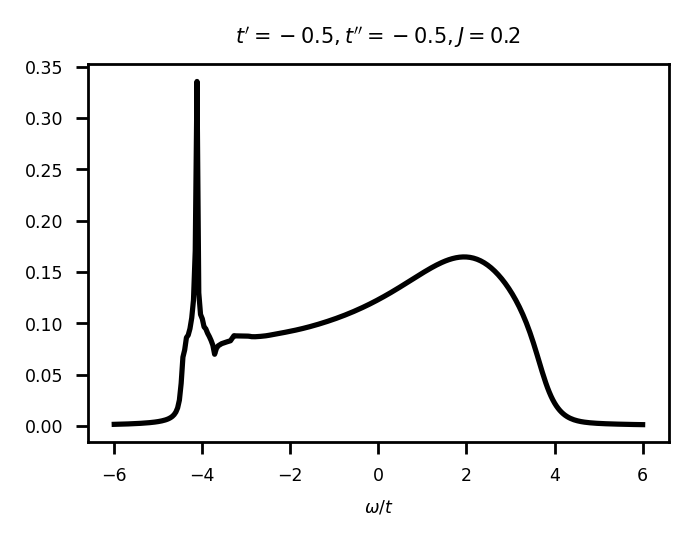

In [138]:
t1, t2, j = X[0]
dos = y[0]

fig, ax = plt.subplots()
ax.plot(np.linspace(-6, 6, 301), dos, color = "black")
ax.set_xlabel("$\omega/t$")
ax.set_title(f"$t'={t1}, t''={t2}, J={j}$");

To turn the continuous spectral function into something we can work with, we've sampled the spectral function at 301 points, producing a 301 dimensional vector. So, each datapoint consists of 3 dimensional input, and a 301 dimensional output.

Here's the problem we want to solve: We have a set of datapoints, consisting of Hamiltonian parameters and their corresponding spectral functions. Can we use KNN to predict the resulting spectral function of a *new* set of Hamiltonian parameters? If we can, we wouldn't have to run the physics computation using the parameters - a huge improvement in computational time!

Notice that there's a new twist in this problem, compared to the house prices: our labels are now *vectors*, instead of scalars. How will we use KNN, which involves taking the mean of the labels? No matter - we can just take the element-wise mean, as below. 

Text(0.5, 0, '$\\omega/t$')

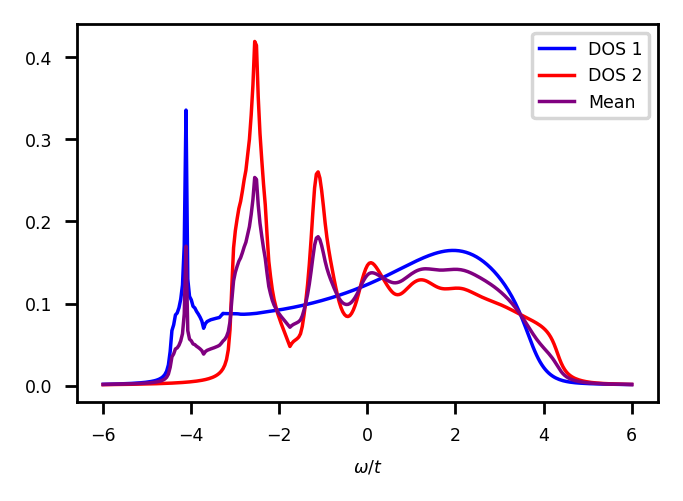

In [139]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-6, 6, 301), y[0], color = "blue", label = "DOS 1", linewidth = 1)
ax.plot(np.linspace(-6, 6, 301), y[500], color = "red", label = "DOS 2", linewidth = 1)
ax.plot(np.linspace(-6, 6, 301), (y[0] + y[500]) / 2, color = "purple", label = "Mean", linewidth = 1)
ax.legend()
ax.set_xlabel("$\omega/t$")

So it's possible, but will taking averages like this really produce good spectral functions? Let's try it out. First, we'll divide the dataset into training, validation, and testing sets:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

And scale the data:

In [46]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

And then we'll run grid search on the KNN hyperparameters to minimize error on the validation set. Let's start by doing so with the Manhattan distance, and trying out weighting schemes with $\frac{1}{d^\alpha}$:

In [47]:
max_alpha = 5
max_k = 20
power_param = 1
weighted_errors = np.zeros((max_alpha + 1, max_k))

for alpha in range(max_alpha + 1):
    print(f"Running alpha = {alpha}")
    for k in range(1, max_k + 1):
        neigh = KNeighborsRegressor(n_neighbors = k, weights = lambda d:1/d**alpha, p = power_param)
        neigh.fit(X_train_scaled, y_train)
        y_pred = neigh.predict(X_val_scaled)
        
        error = mean_squared_error(y_pred, y_val)
        weighted_errors[alpha, k - 1] = error
        
best_index = np.unravel_index(np.argmin(weighted_errors), weighted_errors.shape)
best_alpha = best_index[0]
best_k = best_index[1] + 1
best_mse = np.min(weighted_errors)

print(f"best alpha: {best_alpha}, best k: {best_k}, best mse: {best_mse}")

Running alpha = 0
Running alpha = 1
Running alpha = 2
Running alpha = 3
Running alpha = 4
Running alpha = 5
best alpha: 3, best k: 12, best mse: 0.00030327074405714084


And let's try with the $L_2$ distance:

In [48]:
max_alpha = 5
max_k = 20
power_param = 2
weighted_errors = np.zeros((max_alpha + 1, max_k))

for alpha in range(max_alpha + 1):
    print(f"Running alpha = {alpha}")
    for k in range(1, max_k + 1):
        neigh = KNeighborsRegressor(n_neighbors = k, weights = lambda d:1/d**alpha, p = power_param)
        neigh.fit(X_train_scaled, y_train)
        y_pred = neigh.predict(X_val_scaled)
        
        error = mean_squared_error(y_pred, y_val)
        weighted_errors[alpha, k - 1] = error
        
best_index = np.unravel_index(np.argmin(weighted_errors), weighted_errors.shape)
best_alpha = best_index[0]
best_k = best_index[1] + 1
best_mse = np.min(weighted_errors)

print(f"best alpha: {best_alpha}, best k: {best_k}, best mse: {best_mse}")

Running alpha = 0
Running alpha = 1
Running alpha = 2
Running alpha = 3
Running alpha = 4
Running alpha = 5
best alpha: 4, best k: 10, best mse: 0.00028306122457693716


So it seems that $L_2$ distance is better. We've gotten an optimized KNN algorithm - now let's see how it does on the testing set:

In [51]:
best_knn = KNeighborsRegressor(n_neighbors = best_k, weights = lambda d:1/d**best_alpha, p = 2)
best_knn.fit(X_train_scaled, y_train)
y_pred = best_knn.predict(X_test_scaled)
mean_squared_error(y_pred, y_test)

0.00026651541865955396

But how do the predicted spectral functions actually look in comparison with the ground truths? One way of seeing this is by seeing how the worst predicted spectral functions (in terms of mean squared error) look. If even these spectral functions look pretty close to the ground truth, we can be confident the spectral functions in the whole test set look close. 

Let's order the predicted spectral functions in the test set by mean squared error compared to the ground truth:

In [52]:
mse_list = np.mean((y_pred - y_test) ** 2, axis = 1)
sorted_inds = np.argsort(mse_list)[::-1]
sorted_pred = y_pred[sorted_inds]
sorted_truth = y_test[sorted_inds]

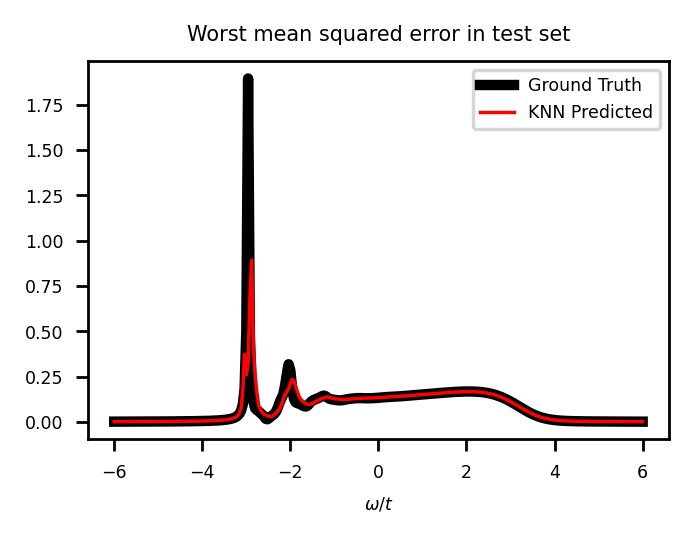

In [53]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-6, 6, 301), sorted_truth[0], color = "black", linewidth = 3, label = "Ground Truth")
ax.plot(np.linspace(-6, 6, 301), sorted_pred[0], color = "red", linewidth = 1, label = "KNN Predicted")
ax.set_title("Worst mean squared error in test set")

ax.legend()
ax.set_xlabel("$\omega/t$");

And let's take a look at what the lower quartile of performance looks like:

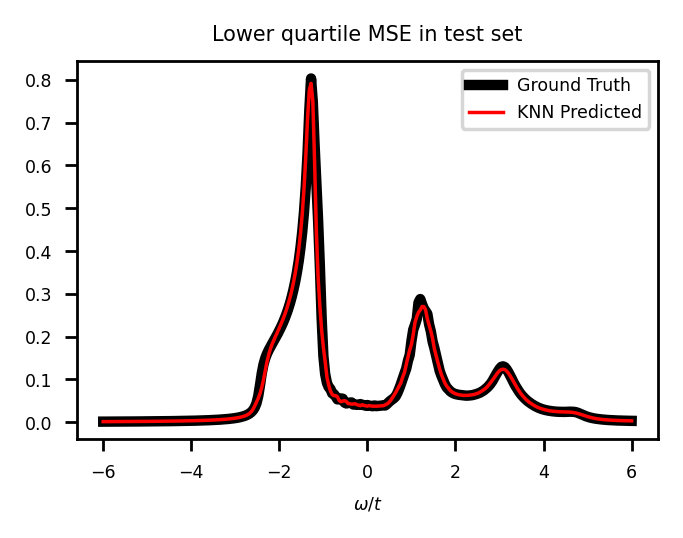

In [54]:
fig, ax = plt.subplots()
test_size = len(sorted_truth)
ax.plot(np.linspace(-6, 6, 301), sorted_truth[test_size // 4], color = "black", linewidth = 3, label = "Ground Truth")
ax.plot(np.linspace(-6, 6, 301), sorted_pred[test_size // 4], color = "red", linewidth = 1, label = "KNN Predicted")
ax.set_title("Lower quartile MSE in test set")

ax.legend()
ax.set_xlabel("$\omega/t$");

Pretty good! Even for the very worst example in the test set, the peak positions and widths are well predicted, and by the time we get to the lower quartile, the spectral functions almost match exactly. 

## Limitations of KNN

We've seen how KNN can be useful in making predictions, despite its simplicity; however, we also need to be careful of its limitations! Let's take a look at some of the limitations of KNN:
- **Irrelevant features** can significantly impact the performance of the algorithm. An irrelevant feature is one that has no predictive power for the label of a point. As KNN assumes that points close in feature space have similar labels, such irrelevant features can mess up the results!
- **KNN can be slow for very large datasets**, as labelling each new point requires looking at training data.
- KNN is especially impacted by **high dimensional datasets** - datasets with a lot of features. This is because the distance the distance metric breaks down in high dimensions: that is, distances between most points become almost the same in high dimensional parameter space. Clearly, this is an issue for KNN! This is known as the **curse of dimensionality** - [this lecture](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote02_kNN.html) discusses this in more depth.

## Conclusion

KNN regression is a simple algorithm - you just look at the closest points in parameter space, and take their weighted average. However, we've seen how KNN can nonetheless be quite effective in predicting the labels of new points - even applying it to a problem of condensed matter physics. There are times when applying KNN produces results that are good enough - which is great, because then you don't have to use more complicated machine learning algorithms! In other cases, KNN can provide a useful benchmark for these other, more sophisticated machine learning algorithms. As with any other ML algorithm, KNN's success is dependent on that particular dataset. Go forth, and may KNN solve (some) of your problems!